# 2D Fourier Transform

In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
images = [ cv2.imread("./images/data/00{}.jpg".format(i), cv2.IMREAD_GRAYSCALE) for i in range(0, 7)] 

In [2]:
def fft2(img: np.array): 
    M, N = img.shape 
    fourier = np.matmul(exp_mu(img), np.matmul(img, exp_nu(img)) )
    return fourier

def inverse_fft2(img: np.array):
    M, N = img.shape 
    inv_fourier = np.matmul(exp_mu(img, inverse = True), np.matmul(img , exp_nu(img, inverse = True))) / (M * N)
    return inv_fourier

def highpass(img, radius = 45): 
    h, w = img.shape[0], img.shape[1]
    filtered = [[0 for _ in range(w)] for _ in range(h)]
    for i in range(h): 
        for j in range(w):
            distance = ((i - h // 2) ** 2 + (j - w // 2) ** 2)
            if distance < radius ** 2:
                continue 
            filtered[i][j] = img[i][j]
    return np.array(filtered)
    
    
def exp_mu(img: np.array, inverse = False):
    M = img.shape[0]
    result = [[0 for _ in range(M)] for _ in range(M)]
    for u in range(M):
        for m in range(M):
            if inverse:
                result[u][m] = np.exp(2j* np.pi * m * u / M )
            else: 
                result[u][m] = np.exp(-2j* np.pi * m * u / M )
    return np.array(result)

def exp_nu(img: np.array, inverse = True):
    N = img.shape[1]
    result = [[0 for _ in range(N)] for _ in range(N)]
    for v in range(N):
        for n in range(N):
            if inverse:
                result[v][n] = np.exp(2j* np.pi * n * v / N )
            else:
                result[v][n] = np.exp(-2j* np.pi * n * v / N )  
    return np.array(result)

def shift(img: np.array):    
    return np.fft.fftshift(img)

def fft_shift(img: np.array):
    return np.abs(shift(fft2())).round().astype(np.uint8)

def show(img: np.array):
    plt.imshow(fft_shift(img), cmap='gray')
    

## Azimuthal Averaging

In [3]:
def azimuthal_averaging(img: np.ndarray):
    h, w = img.shape 
    center = (h // 2, w // 2) 
    max_radius = np.sqrt(center[0] ** 2 + center[1] ** 2) 
    if max_radius != int(max_radius):
        max_radius += 1
    max_radius = int(max_radius)
    cum_sum_freq = np.array([0 for _ in range(max_radius)])
    pixels = np.array([0 for _ in range(max_radius)])
    for i in range(h):
        for j in range(w):
            radius = int(np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2))
            cum_sum_freq[radius] += img[i][j]
            pixels[radius] += 1
    cum_sum_freq = cum_sum_freq / pixels 
    cum_sum_freq = cum_sum_freq[::-1]
    return cum_sum_freq
    

In [6]:
def pipeline(img): 
    fft_img = fft2(img) 
    fft_shifted = np.fft.fftshift(fft_img)
    highpass_img = highpass(fft_shifted, radius = 45)
    plt.imshow(np.log(np.abs(highpass_img)), cmap='gray')
    inv_fft_img = inverse_fft2(highpass_img)
    return np.abs(inv_fft_img)
    

/var/folders/x1/tylp6nfj5xnb74kpdk36gzzw0000gn/T/ipykernel_41317/3601713754.py:5: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(highpass_img)), cmap='gray')


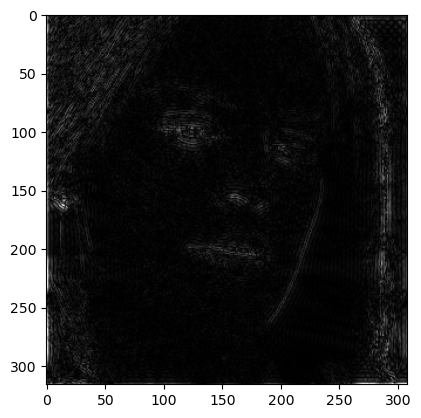

In [7]:
for i in range(7):
    img = pipeline(images[i])
    plt.imshow(img, cmap = "gray")
    plt.savefig("./images/highpassed/00{}.jpg".format(i))

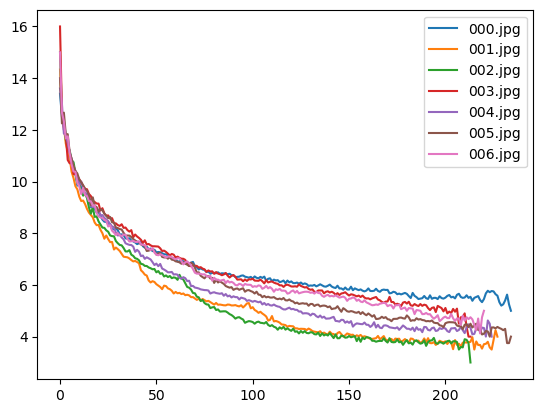

In [8]:
for i in range(7):
    img = images[i]
    fft_img = fft2(img)
    azimuthal = azimuthal_averaging(np.log(np.abs(fft_img)))
    plt.plot(azimuthal, label = "00{}.jpg".format(i))
plt.legend()